In [5]:
import numpy as np
import gymnasium as gym
from gymnasium.spaces import MultiBinary
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.logger import configure
from stable_baselines3.common.callbacks import BaseCallback
import os

# 스마트 팩토리 환경 생성
class SmartFactoryEnv(gym.Env):
    def __init__(self, n_machines=10, energy_limit=18):
        super(SmartFactoryEnv, self).__init__()
        self.n_machines = n_machines
        self.energy_limit = energy_limit

        # Multi-Binary 행동 공간
        self.action_space = MultiBinary(n_machines)

        # 관찰 공간
        self.observation_space = gym.spaces.Box(
            low=0, high=1, shape=(n_machines + 1,), dtype=float
        )

        self.state = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = np.zeros(self.n_machines + 1, dtype=float)
        return self.state, {}

    def step(self, action):
        # 에너지 사용량과 생산량 계산
        energy_usage = np.dot(np.random.uniform(1, 2, self.n_machines), action)
        production = np.dot(np.random.uniform(1, 3, self.n_machines), action)
        penalty = max(0, energy_usage - self.energy_limit)
        
        # 보상 계산
        reward = production - energy_usage - penalty

        # 상태 업데이트
        self.state = np.concatenate([action, [energy_usage]])

        # 종료 조건
        done = energy_usage > self.energy_limit * 2
        return self.state, reward, done, False, {}

    def render(self):
        print(f"Machines: {self.state[:-1]}, Energy Usage: {self.state[-1]}")

# 보상을 출력하는 콜백 클래스
class RewardLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardLoggerCallback, self).__init__(verbose)

    def _on_step(self):
        # 주기적으로 보상 출력 (1000 스텝마다)
        if self.n_calls % 1000 == 0:
            print(f"Step: {self.n_calls}, Recent Reward: {self.locals['rewards']}")
        return True

# 로그 저장 디렉토리 설정
log_dir = "./logs/"
os.makedirs(log_dir, exist_ok=True)

# 학습 환경 생성 및 Monitor로 래핑
train_env = Monitor(SmartFactoryEnv(n_machines=10, energy_limit=18), filename=log_dir)
env = DummyVecEnv([lambda: train_env])

# PPO 모델 생성
model = PPO("MlpPolicy", env, verbose=1)

# 로그 설정
new_logger = configure(log_dir, ["stdout", "csv", "tensorboard"])
model.set_logger(new_logger)

# 학습 - RewardLoggerCallback 사용
model.learn(total_timesteps=200000, callback=RewardLoggerCallback())


Using cuda device
Logging to ./logs/


/usr/local/lib/python3.8/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Step: 1000, Recent Reward: [1.0658484]
Step: 2000, Recent Reward: [2.4157393]
-----------------------------
| time/              |      |
|    fps             | 1456 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
Step: 3000, Recent Reward: [4.355744]
Step: 4000, Recent Reward: [3.3777492]
-----------------------------------------
| time/                   |             |
|    fps                  | 1082        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010824179 |
|    clip_fraction        | 0.16        |
|    clip_range           | 0.2         |
|    entropy_loss         | -6.92       |
|    explained_variance   | -0.000832   |
|    learning_rate        | 0.0003      |
|    loss                 | 440         |
|    n_updates            | 10          |
|    

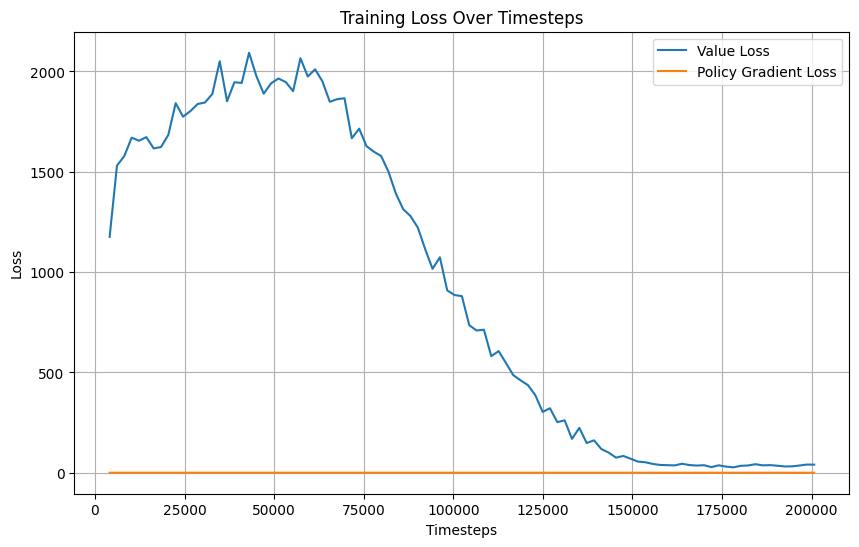

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 로그 파일 경로
log_csv_path = "./logs/progress.csv"

# CSV 파일 읽기
data = pd.read_csv(log_csv_path)

plt.figure(figsize=(10, 6))
plt.plot(data["time/total_timesteps"], data["train/value_loss"], label="Value Loss")
plt.plot(data["time/total_timesteps"], data["train/policy_gradient_loss"], label="Policy Gradient Loss")
plt.xlabel("Timesteps")
plt.ylabel("Loss")
plt.title("Training Loss Over Timesteps")
plt.legend()
plt.grid()
plt.show()


In [3]:
from stable_baselines3.common.evaluation import evaluate_policy

# 평가 환경 생성 및 Monitor 래핑
eval_env = Monitor(SmartFactoryEnv(n_machines=5, energy_limit=10), filename=log_dir)

# 학습된 모델 평가
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10, render=False)
print(f"Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")


KeyboardInterrupt: 

In [ ]:
# 보상 시각화
rewards = []
obs = eval_env.reset()
done = False
for _ in range(1000):  # 최대 1000 스텝 동안 평가
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _ = eval_env.step(action)
    rewards.append(reward)
    if done:
        obs = eval_env.reset()

plt.figure(figsize=(10, 6))
plt.plot(rewards, label="Reward")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title("Rewards Over Steps")
plt.legend()
plt.grid()
plt.show()
